## Processing of the University of Hawaii Sea Level Center tidal gauge data

This notebook illustrates how to get sea level data from the University of Hawaii Sea Level Centre (https://uhslc.soest.hawaii.edu/) and process them to isolate a number of components like tides and storm surge. This notebook focuses on New Zealand datasets but the website hosts data for all over the world.

The data is open access but and can be ackowledged by citing the following reference:
Caldwell, P. C., M. A. Merrifield, P. R. Thompson (2015), Sea level measured by tide gauges from global oceans — the Joint Archive for Sea Level holdings (NCEI Accession 0019568), Version 5.5, NOAA National Centers for Environmental Information, Dataset, doi:10.7289/V5V40S7W.

Here we focus on the research quality datasets available. UHSLC has also more up to date but less curated datasets available but that is only for a small fraction of the New Zealand datasets.

We are working with python and the following libraries:
 - `xarray` is used to retrieve the data from the UHSLC opendap server and manipulate it.
 - `matplotlib` is used from plotting
 - `cartopy` is used to get maps to plot the data location one
 - `os` is used to deal with file paths
 - `datetime` is used to deal with dates.
 - `pandas` is a library for the manupulation of dataframe
 - `numpy` is a library to manupulate and do calculations on arrays

In [1]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.dates import num2date,date2num
import os
from datetime import datetime
import pandas as pd
import numpy as np
%matplotlib inline

### Loading and formatting the data

Here is a list of the New Zealand location for which UHSLC has data that is still being updated. If you look on their website you will be able to find a small number of dataset that contain past records and have been discontinued a while ago. The present url of the UHSLC opendap server is also set here.

In [2]:
research_datasets = {
    'Wellington': 'h071a.nc',
    'Bluff': 'h072a.nc',
    'Tauranga': 'h073a.nc',
    'Taranaki': 'h076a.nc',
    'Nelson': 'h077a.nc',
    'MarsdenPoint': 'h398a.nc',
    'JacksonBay_1': 'h403a.nc',
    'JacksonBay_2': 'h403b.nc',
    'Timaru': 'h665a.nc',
    'Lyttelton': 'h667a.nc',
    'Napier': 'h668a.nc',
    'PortChalmers': 'h669a.nc'
}
uhslc_research_pacific_datasets_url =\
   'https://uhslc.soest.hawaii.edu/opendap/rqds/pacific/hourly'

In this notebook we are going to work with the Nelson dataset. We start by connecting to the dataset.
The dataset contains a main variable that varies with time called 'sea_level' which contains the sea level data. It also contains many other variables like lon/lat which hold the metadata of the dataset.

In [3]:
location = 'Nelson'
dset = xr.open_dataset(os.path.join(uhslc_research_pacific_datasets_url,
                                    research_datasets[location]))
dset

<xarray.Dataset>
Dimensions:               (record_id: 1, time: 311205)
Coordinates:
  * time                  (time) datetime64[ns] 1984-06-30T15:00:00 ... 2019-...
  * record_id             (record_id) int16 771
Data variables: (12/13)
    station_name          (record_id) |S64 ...
    station_country       (record_id) |S64 ...
    version               |S64 ...
    ssc_id                (record_id) |S64 ...
    reference_code        |S64 ...
    sea_level             (record_id, time) float32 ...
    ...                    ...
    lon                   (record_id) float32 ...
    station_country_code  (record_id) float32 ...
    uhslc_id              (record_id) int16 ...
    gloss_id              (record_id) float32 ...
    decimation_method     (record_id) int16 ...
    reference_offset      (record_id) int16 ...
Attributes:
    title:                  JASL/UHSLC Research Quality Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2020-10-28T00:12:03Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The Joint Archive for Sea Level (JASL) Research Q...
    processing_level:       The JASL receives hourly data from regional and n...
    acknowledgment:         The JASL/UHSLC Research Quality Data Set is suppo...

We can plot the longitude and latitude information to make sure of the exact location of the data. The data is indeed coming from Nelson.

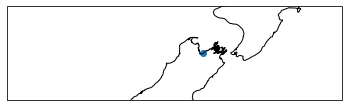

In [4]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.scatter([float(dset.lon)],[float(dset.lat)])

plt.show()

We load the sea_level variable in memory which should speed up the rest of the work.

In [5]:
elev = dset.sea_level.load()
elev

<xarray.DataArray 'sea_level' (record_id: 1, time: 311205)>
array([[1397.,  797.,  617., ..., 1845., 2264., 2837.]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1984-06-30T15:00:00 ... 2019-12-31T10:59...
  * record_id  (record_id) int16 771
Attributes:
    long_name:  relative sea level
    units:      millimeters
    source:     in situ tide gauge water level observations
    platform:   station_name, station_country, station_country_code, uhslc_id...

If we plot the date, we can see that it is very sparse initially and becomes more or less ininterupted since July 2001 but is quite dense since 1996.

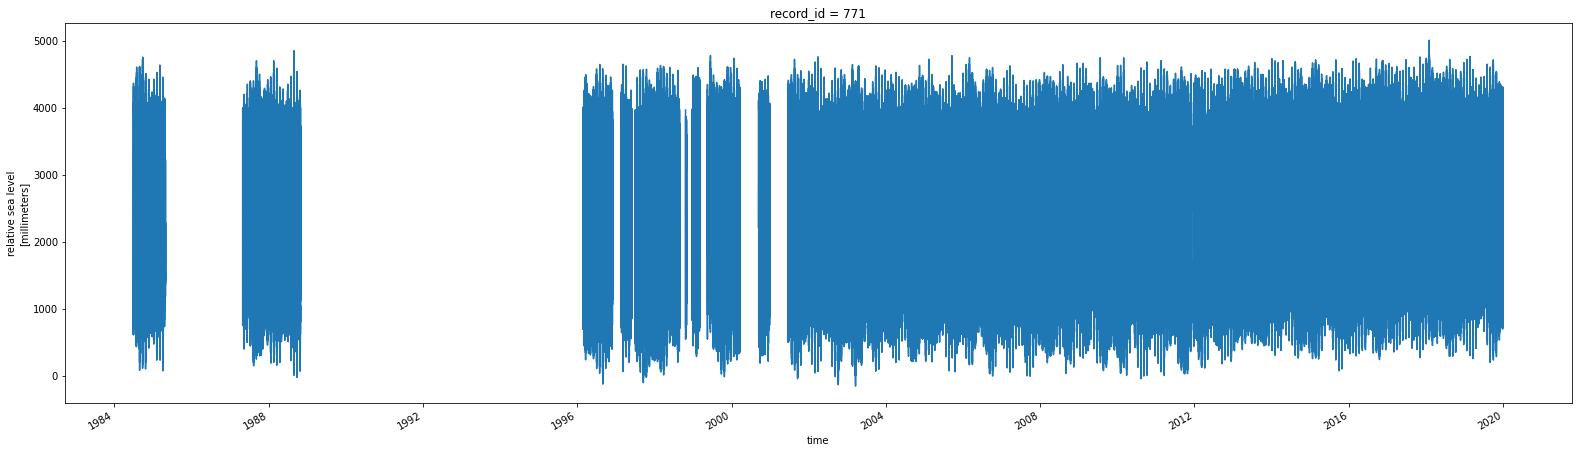

In [6]:
plt.figure(figsize=(27,7))
elev.plot()

Let's say for now we are only going to use the data from 1996 onwards.

In [7]:
elev = elev.sel(time=slice(datetime(1996,1,1), None))

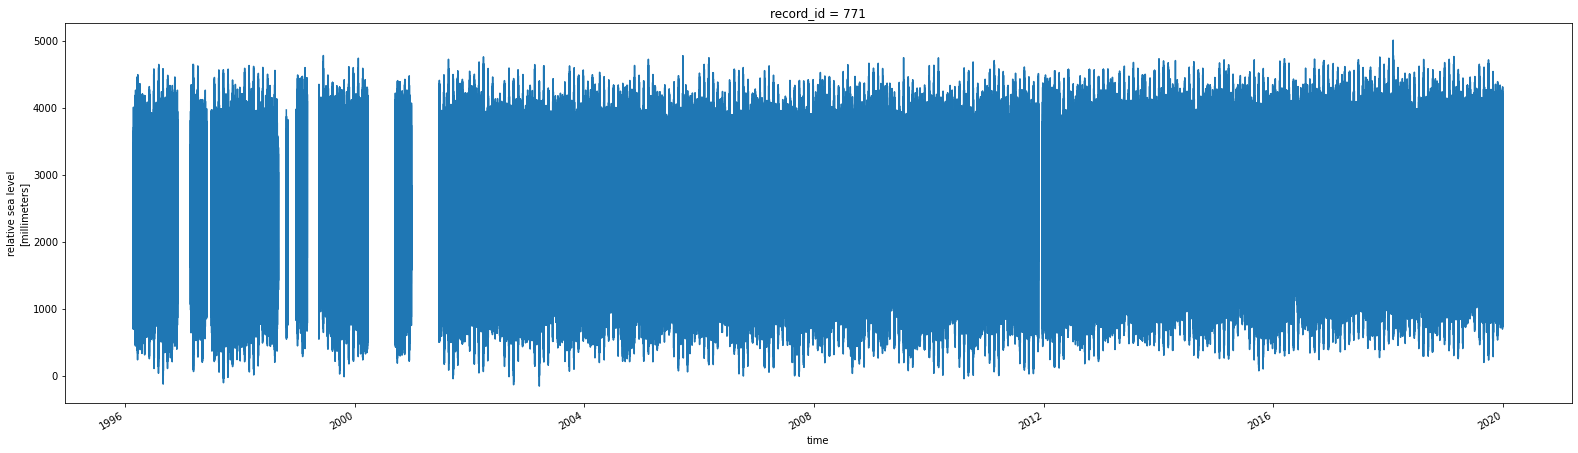

In [8]:
plt.figure(figsize=(27,7))
elev.plot()

Now we have the data, we will prepare for the analysis. First we drop the 'record_id' dimension as it is of little use, we rename the variable 'elev' and convert the data from millimeters to meters. We copy over the attributes of the variable and update the unit name to meters.

In [9]:
elev = elev.squeeze().drop_vars(['record_id'])\
           .rename('elev')
elev=(elev/1000).assign_attrs(elev.attrs)
elev.attrs.update({'units': 'meters'})
elev

<xarray.DataArray 'elev' (time: 210372)>
array([  nan,   nan,   nan, ..., 1.845, 2.264, 2.837], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1996-01-01 ... 2019-12-31T10:59:59.971200
Attributes:
    long_name:  relative sea level
    units:      meters
    source:     in situ tide gauge water level observations
    platform:   station_name, station_country, station_country_code, uhslc_id...

Then we convert our xarray dataset into a pandas dataframe which is the data structure used by Toto, the library that we used for the analysis.

In [10]:
elev = elev.to_dataframe()
elev

,elev
time,
1996-01-01 00:00:00.000000,NaN
1996-01-01 01:00:00.028800,NaN
1996-01-01 01:59:59.971200,NaN
1996-01-01 03:00:00.000000,NaN
1996-01-01 04:00:00.028800,NaN
...,...
2019-12-31 07:00:00.028800,1.315
2019-12-31 07:59:59.971200,1.470
2019-12-31 09:00:00.000000,1.845


### Data cleaning

The first step when working with observations is to clean the data. Here we are working with research grade data so the data should already very clean and does not really need much cleaning.
Just for the sake of illustration we go through a few steps of cleaning that might be useful in other cases.

We start by loading a number of processing functions. We will explain what each function does as we go. Some of the functions come from the storm surge project repository, some from [Toto](https://github.com/calypso-science/Toto) a water level tool developed as part of the storm surge project.

In [11]:
from storm_surge.timeseries_processing.core_routines.toolbox import filled_gap
from storm_surge.timeseries_processing.core_routines.check import plot_graph as select_points_to_delete
from toto.filters.despike_phasespace3d import despike_phasespace3d
import copy

First we use a function that turns the dataframe into an evenly spaced dataframe (interval dt seconds) starting at the firstnon nan value of df. The values of the new dataframe are sourced from the input dataframe in a nearest neighbout fashion. This will enforce the spacing between time indices to be exactly uniform.
Then we resample the data using an hourly frequency.
Those operations have little impact here except for rounding all indices and getting rid of a number of nans. They can be used to turn higher resolution non uniformly sampled data into a lower resolution uniformly sampled array.

In [12]:
df = filled_gap(copy.deepcopy(elev), dt=3600)
df = df.resample('1H').nearest()

<AxesSubplot:xlabel='time'>

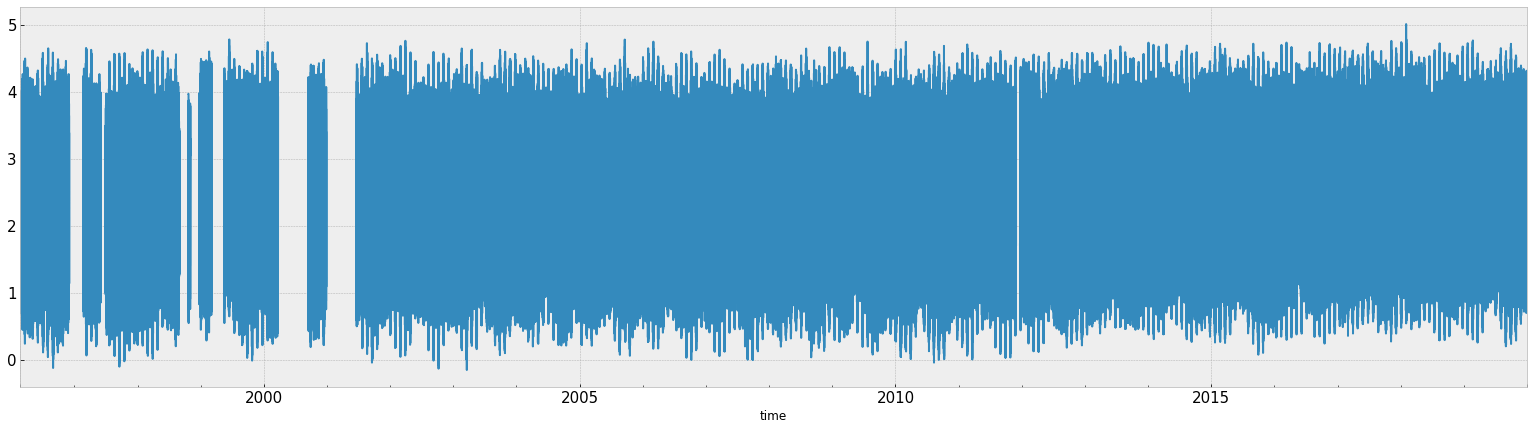

In [13]:
plt.figure(figsize=(27,7))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
df['elev'].plot()

Cleaning data often consists mostly of removing spikes in the data. First we apply a despiking algorithm implemented in Toto which is was initially designed to despike acoustic velocimeter data (Mori, N., Suzuki, T. and Kakuno, S., 2007. Noise of acoustic Doppler velocimeter data in bubbly flows. Journal of engineering mechanics, 133(1), pp.122-125.)
Because there are no spikes in the data, the algorithm does nothing to the data (as shown by plotting the difference between the despiked data and the data priro to despiking) which is reassuring in itself.

In [14]:
df['phasespace'] = despike_phasespace3d(df['elev'])

<AxesSubplot:xlabel='time'>

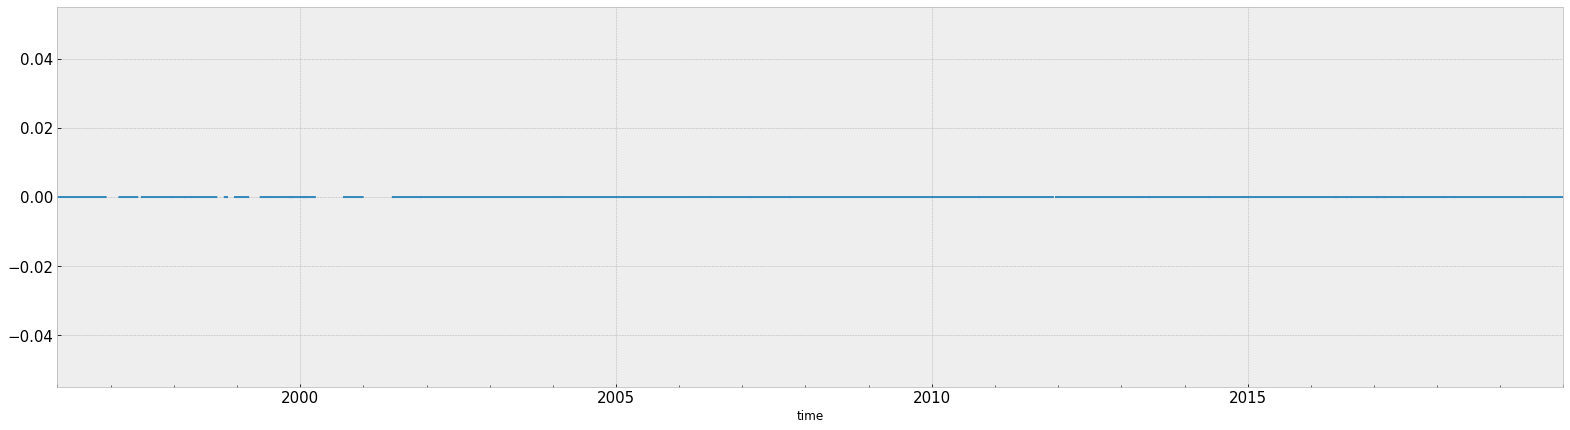

In [15]:
plt.figure(figsize=(27,7))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
(df['elev']-df['phasespace']).plot()

In [16]:
df['elev'] = df['phasespace']
df = df.drop(columns='phasespace')

We apply here a second filtering algorithm based on a threshold method. Any point larger than the mean of the signal plus 3 times the standard variation is removed. Again, this does not change the time series.

In [17]:
abs_threshold = 3

df['despiked'] = df['elev'].copy()

y = df['elev'].to_numpy(copy=True)
y = y - np.nanmean(y)
ind = np.abs(y) > abs_threshold*np.nanstd(y)
df['despiked'][ind] = np.nan

<AxesSubplot:xlabel='time'>

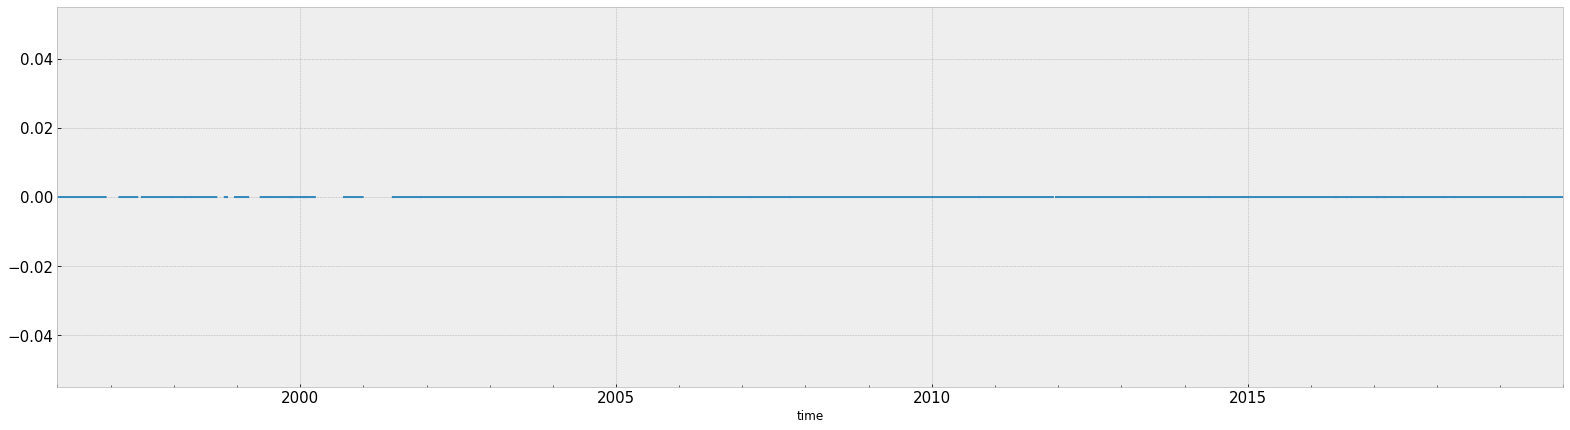

In [18]:
plt.figure(figsize=(27,7))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
(df['elev']-df['despiked']).plot()

In [19]:
df['elev'] = df['despiked']
df = df.drop(columns='despiked')

The cleaning/despiking routines have done the bulk of the cleaning job but often there are still a few points that might need removing manually. We can do so using the check function of the storm surge repository.
First we need to switch matplotlib from iline to interactive mode.

Then, the function display the data in the list of dataframes in an interactive window. By default the cursor is in selection mode. This means if you left click, hold the left click, move the cursor and then release (draw a bounding box using the mouse) all the data in the drawn bounding box gets selected.

Most of the time, we only want to select a few points here and there the best way to go about it is to zoom on the data and then do the selection. To do so, first click on the magnifying glass icon, then zoom by drawing a bounding box over the area of interest. We the points to select are clearly identifiable, switch back to selection mode by uncliking the magnifying glass icon and then draw a bounding box around the points to select.

If other points need to be selected, clic on the home icon to reset the zoom level and repeat the same process. The tricky thing is to remember to clic and unclic the magnifying glass icon.

When all the points that need deleting are selected, then close the window and the function will output the coordinates the points to delete in the shape of a list of pairs of indices, where each pair of indices describe the start and the end of the index range over which data needs deleting.

In [20]:
# Switching to matplotlib interactive mode to enable 
# the usafe of the editing widgets
%matplotlib

points_to_delete = select_points_to_delete([df],
                                           ['elev'],
                                           ['Raw'],
                                           save=None,
                                           eventname='clean')

Using matplotlib backend: Qt5Agg


We switch back matplotlib to inline mode and print the selected point ranges.

In [21]:
%matplotlib inline
if 'delete' in points_to_delete: # points have to have been selected for this to work
    for d in points_to_delete['delete']:
        print(num2date(d[0]), num2date(d[1]))

We now delete the points from the dataframe.

In [22]:
def delete_manually(ds,
                    times):
    """
    Inputs:
      - ds (DataFrame): Dataframe from which data needs deleting (replacing by nans)
      - times (list): List of pairs of date indices describing the intervals over
                      which the data has to be delete.
    Output:
      The input DataFrame with a number of data blanked out.
    """
    for time in times:
        ind = np.logical_and(date2num(ds.index) >= time[0],
                             date2num(ds.index) <= time[1])
        ds[ind]=np.nan
    return ds

In [23]:
if 'delete' in points_to_delete: # points have to have been selected for this to work
    df['elev'] = delete_manually(df['elev'],
                                 points_to_delete['delete'])

Here the final clean data timeseries

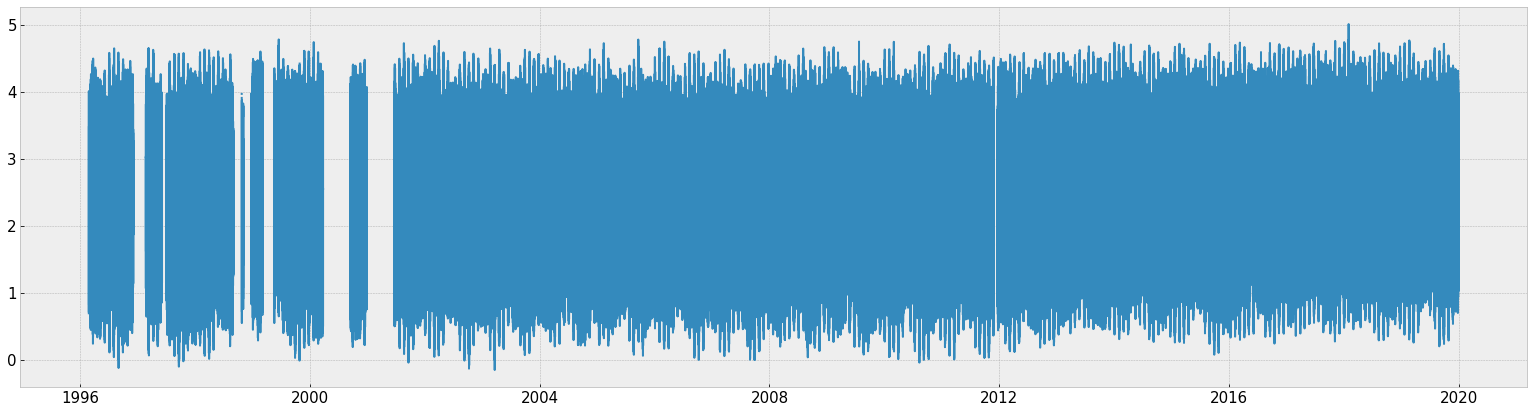

In [24]:
plt.figure(figsize=(27,7))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot(df)

### Data analysis

Now that the data is clean enough, let's start with the analysis. We are going to split the total water level timeseries into the following components:
  - `trend`: the trend includes mean total water level plus the linear variation of the water level over the time of the whole dataset.
  - `montly mean sea level`: this is a term that contains the low frequency variation of the signal at period of a month or larger.
  - `astronomical tides`: the astronomical tides are the variation of the watel level dur to the Earth's rotation and gravitational effects of celestial bodies such as the Moon and the Sun. 
  - `storm surge`: this is the variation of the sea water level as a results of the changes in wind and atmospheric pressure.
  - `residuals`: the residual is the signal left when subtracting all the other component to the initial water level data. Those will contain a number of high frequency signal due to processes such as swell or infragravity waves. Those will also contain some energy near the frequency of the tides such as non-linear tidal residuals or tidal-surge interation.

Here we import the lowpass Lanczos filter function from the Toto library which we will use to filter the storm surge signal and a linear regression function to fit the tides.

In [25]:
from toto.filters.lanczos_filter import lanczos_filter
from scipy.stats import linregress

First of all we store the location of the missing data so that we can make sure those points are definitely blanked out in the final dataframe.
Then we detrend the data. For that we first replace all missing data with the mean of the timeseries and use the detrend function from toto

In [26]:
# Storing NaNs position
f = np.where(np.isnan(df['elev'].values) == 1)
    
# Get the detrended time series using a linear approach
df['et'] = df['elev']
# Step 1: Store non nan data
not_nan_ind = ~pd.isna(df['et'])
x =  date2num(df['et'][not_nan_ind].index)
y = df['et'][not_nan_ind].values
# Step2: Fit linear curve
m, b, r_val, p_val, std_err = linregress(x, y)
# Step3: Store the trend
df['trend'] = m*date2num(df['et'].index) + b
# Strep4: Remove trend from data
df['et'] = df['et'] - df['trend']

del x,y

<AxesSubplot:xlabel='time'>

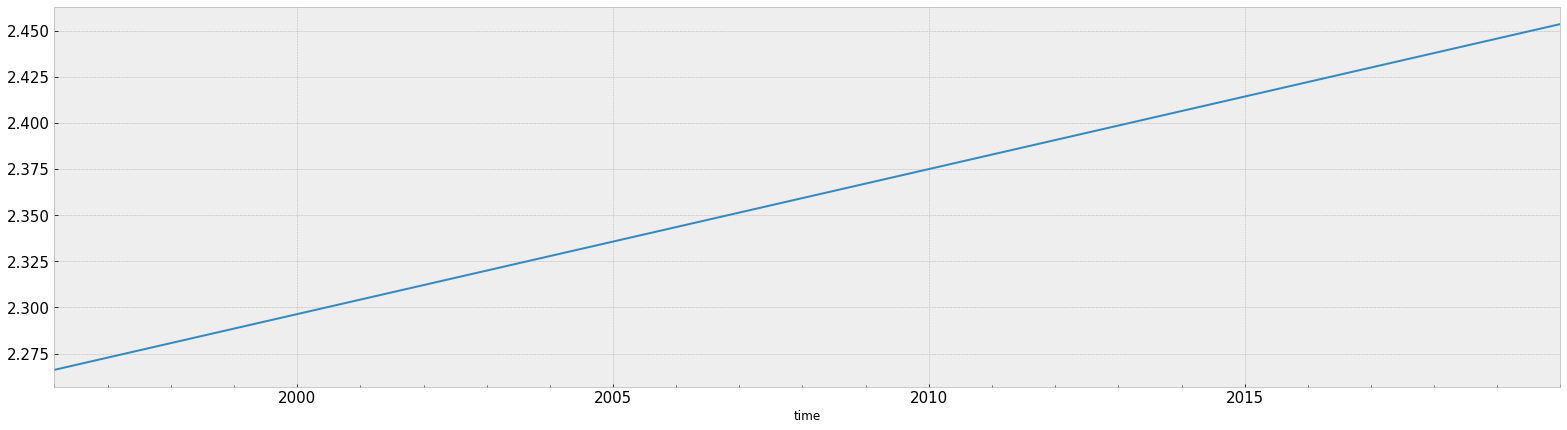

In [27]:
plt.figure(figsize=(27,7))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
df['trend'].plot()

Now we will extract the astronomical tides out of the timeseries. First, we fit the curves using the toto function fit tides which is a wrapper around UTide (https://github.com/wesleybowman/UTide). The constituents are set to 'auto' which means that UTide tries to fit as many constituents as possible. 

In [28]:
# We fit the astronomical tides he tidal analysis
constituents = df.TideAnalysis._fit_tides(mag='et',
                                          args={'minimum SNR': 2,
                                                'trend': False,
                                                'latitude': float(dset.lat),
                                                'constit': 'auto'
                                            })

{'trend': False, 'constit': 'auto', 'method': 'ols', 'conf_int': 'linear', 'Rayleigh_min': 2}
solve: matrix prep ... solution ... done.


One can inspect the constituent object to get the details of the constituents axtracted by UTide.

In [29]:
constituents

{'name': array(['M2', 'S2', 'N2', 'K2', 'K1', 'NU2', 'L2', 'SA', 'MU2', '2N2',
        'SK3', 'T2', 'M3', 'M4', 'MS4', 'P1', 'O1', 'LDA2', 'H1', 'SO3',
        'MK3', 'S1', 'SSA', 'EPS2', 'MF', 'Q1', 'MK4', 'H2', 'GAM2',
        'ETA2', 'MKS2', 'R2', 'J1', 'SK4', 'OQ2', 'MSN2', 'MSF', 'MN4',
        'M8', 'M6', 'MO3', 'OO1', '2MS6', '2MN6', '2SK5', '2Q1', 'MSM',
        'SIG1', 'S4', 'PHI1', '2MK5', 'NO1', '3MK7', 'PI1', 'RHO1', 'MM',
        'PSI1', '2MK6', 'THE1', 'SN4', 'ALP1', '2SM6', 'TAU1', 'CHI1',
        'BET1', 'SO1', 'MSK6', 'UPS1'], dtype=object),
 'aux': {'frq': array([8.05114007e-02, 8.33333333e-02, 7.89992487e-02, 8.35614924e-02,
         4.17807462e-02, 7.92016200e-02, 8.20235526e-02, 1.14074104e-04,
         7.76894680e-02, 7.74870967e-02, 1.25114080e-01, 8.32192592e-02,
         1.20767101e-01, 1.61022801e-01, 1.63844734e-01, 4.15525871e-02,
         3.87306544e-02, 8.18211814e-02, 8.03973266e-02, 1.22063988e-01,
         1.22292147e-01, 4.16666721e-02, 2.28159110e-04,

Now that we have the constituents, we can generate the tidal elevation as a timeseries for all times of the original dataset.

In [30]:
df = pd.concat([df, df.TideAnalysis\
                          ._tidal_elevation_from_constituents(constituents=constituents)\
                          .rename(columns={'tidal_elevation': 'tide'})],
                   axis=1)

prep/calcs ... done.


With the constituents, the tidal elevation is reconstituted accurately even over the data gaps.

(412008.0, 412344.0)

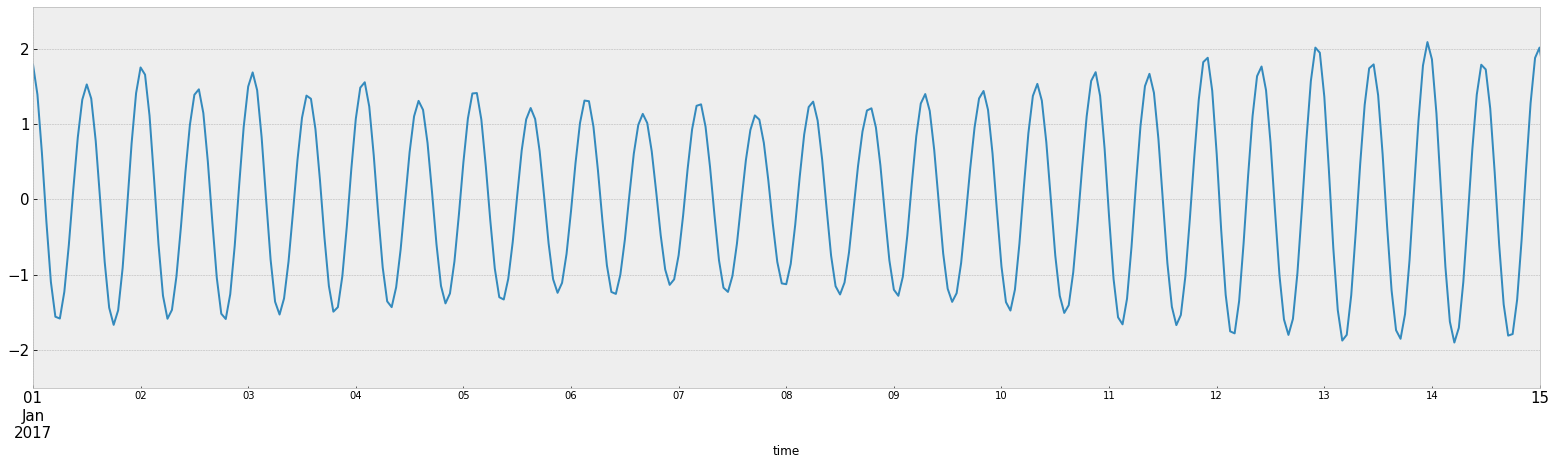

In [31]:
plt.figure(figsize=(27,7))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
df['tide'].plot()
plt.xlim(xmin=datetime(2017,1,1), xmax=datetime(2017,1,15))

We now subtract the tides to the already detrended signal.

In [32]:
# Remove the tides
df['et'] = df['et'] - df['tide']

The next step is to separate all the low frequency variations in the shape of montlhy mean sea level using a cutoff frequency frequency of 30 days. We do so using a rolling window average of size 30 days.

In [33]:
# Now we extract the mean sea level anomaly using a 30-day running average of the non-tidal residual (Haigh et al. 2014)
df['msea'] = df['et'].rolling(window=int(24*30), min_periods=int(24*30/2), center=True).mean()

<AxesSubplot:xlabel='time'>

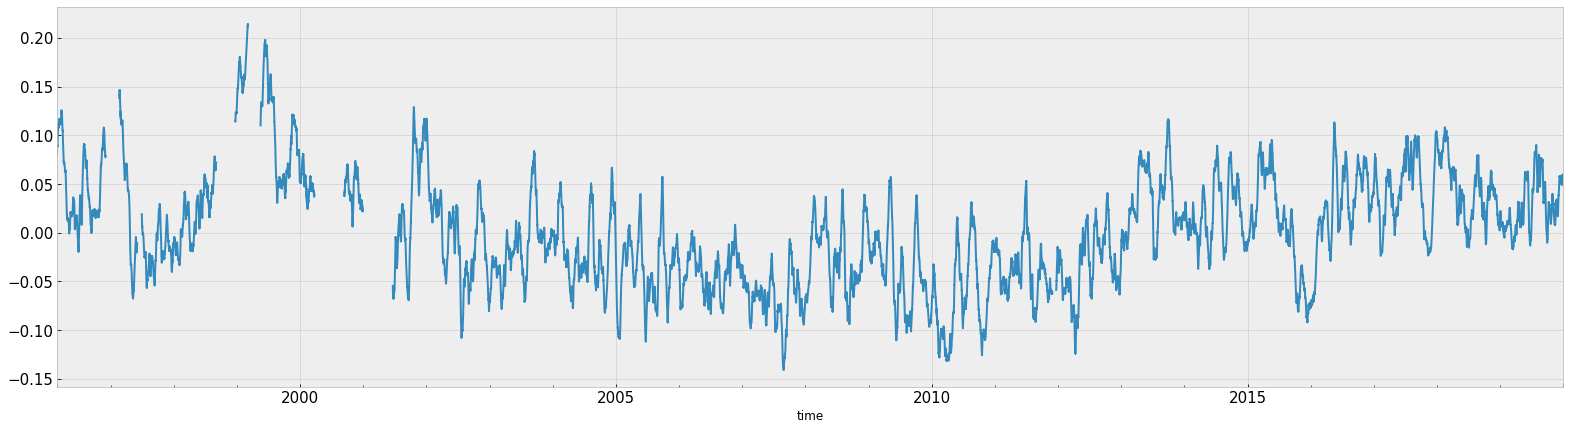

In [34]:
plt.figure(figsize=(27,7))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
df['msea'].plot()

We now subtract the monthly mean sea level variations.

In [35]:
df['et'] = df['et'] - df['msea']

The atmospheric part of storm surge is extracted using a lowpass Lanczos filter of cutoff frequency 30 hours which corresponds to the inertial frequency ... for the latitudes. Because any nan will result in a 30 hours gap in the storm surge we fill all gaps of maximum size 3 hours using second order Akima interpolation before applying the lanczos filter.

In [36]:
# We extract the storm surge
df['ss'] = lanczos_filter(df['et'].interpolate(axis=0, limit=3, limit_area='inside', method='akima', order=2),
                          args={'window':30, 'type':'lanczos lowpas 2nd order'})

(412008.0, 420768.0)

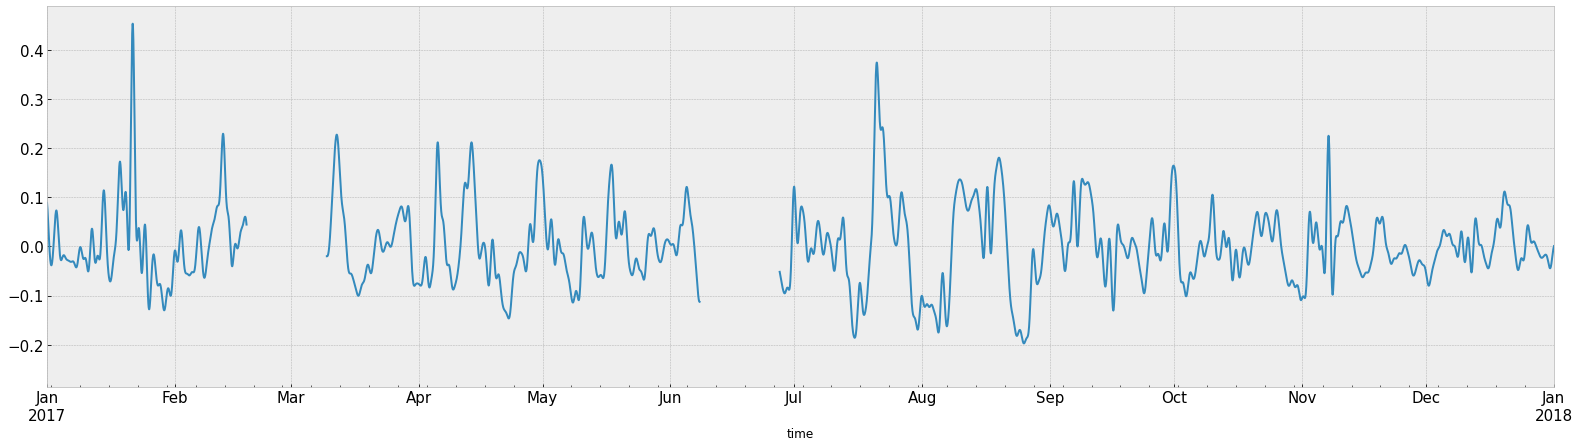

In [37]:
plt.figure(figsize=(27,7))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
df['ss'].plot()
plt.xlim(xmin=datetime(2017,1,1), xmax=datetime(2018,1,1))

We subtract that component to what is left of the signal and get the residuals

In [38]:
df['res'] = df['et'] - df['ss']

We can derived another measure of surge using that data called skew curve. The skew is defined as the difference between the maximum total water level over a tidal cycle and that of the maximum tidal elevation over the same tidal cycle. For total water level we use here tidal elevation, storm surge and the residuals and leave the lower frequency part of the total water level out.

Again we use a function dedicated to the extraction of skew surge implemented in Toto.

In [39]:
# Get skew surge
# From tide + ss + residuals
print('\tSkew surge filtering')
df['et'] = df['res'].interpolate(axis=0, limit=3, limit_area='inside', method='akima', order=2) + df['ss'] + df['tide']
df = pd.concat([df, df.TideAnalysis.skew_surge(mag='et',
                                               args={'minimum SNR': 2,
                                                     'trend': False,
                                                     'latitude': float(dset.lat),
                                                     'constituents':constituents,
                                                     'tide_dt': 60*60})],
               axis=1)

	Skew surge filtering
prep/calcs ... done.


The scatter plot below which shows the storm surge magnitude at the top of the tide versus the skew surge we can see that in Nelson when the storm surge is large we can see a few events for which the skew surge is a lot larger than the skew surge.

Text(0, 0.5, 'Skew surge')

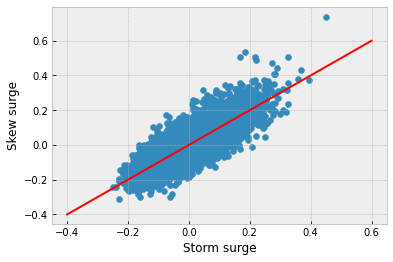

In [40]:
plt.scatter(df['ss'], df['skew_surge_magnitude'])
plt.plot([-0.4, 0.6], [-0.4, 0.6], color='r')
plt.xlabel('Storm surge')
plt.ylabel('Skew surge')

Finally, looking at the residuals over the month of september 2017, we can see that they contain a structured signal that seems to involve a cosine of period about 2 weeks multiplied by a cosine of period close to that of the tides (~12-13 hours).

(417840.0, 418560.0)

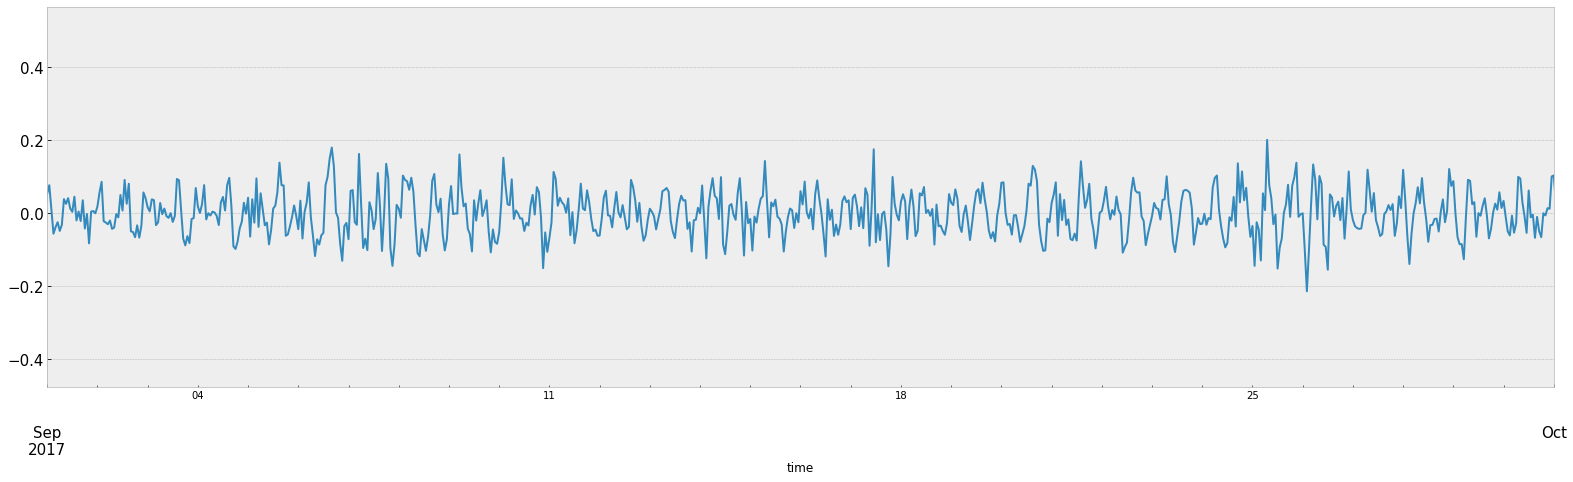

In [41]:
plt.figure(figsize=(27,7))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
df['res'].plot()
plt.xlim(xmin=datetime(2017,9,1), xmax=datetime(2017,10,1))

In conclusion, in this notebook we have downloaded sea water level data from a server operated by the University of Hawaii Sea Level Center. We have cleaned that data or more exactly gone through a number of functions that would have been helpful to clean the data if they had needed it. Finally we have split the data in a number of components that relate to different processes governs variations in sea water level.

We now have a DataFrame that can be used for further work.

In [42]:
df

,elev,et,trend,tide,msea,ss,res,skew_surge_magnitude,skew_surge_lag,tidal_elevation_maximum_over_tidal_cycle,tidal_elevation_maximum_time_over_tidal_cycle,total_water_level_maximum_over_tidal_cycle
time,,,,,,,,,,,,
1996-02-23 06:00:00,NaN,NaN,2.266107,-1.550426,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
1996-02-23 07:00:00,0.696,NaN,2.266107,-1.640120,0.082313,NaN,NaN,NaN,NaN,NaN,NaT,NaN
1996-02-23 08:00:00,0.835,NaN,2.266108,-1.359485,0.082044,NaN,NaN,NaN,NaN,NaN,NaT,NaN
1996-02-23 09:00:00,1.473,NaN,2.266109,-0.778810,0.081835,NaN,NaN,NaN,NaN,NaN,NaT,NaN
1996-02-23 10:00:00,2.165,NaN,2.266110,-0.010468,0.081513,NaN,NaN,NaN,NaN,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 06:00:00,1.360,NaN,2.453508,-1.156799,0.059656,NaN,NaN,NaN,NaN,NaN,NaT,NaN
2019-12-31 07:00:00,1.315,NaN,2.453509,-1.302895,0.059571,NaN,NaN,NaN,NaN,NaN,NaT,NaN
2019-12-31 08:00:00,1.470,NaN,2.453510,-1.137558,0.059407,NaN,NaN,NaN,NaN,NaN,NaT,NaN
